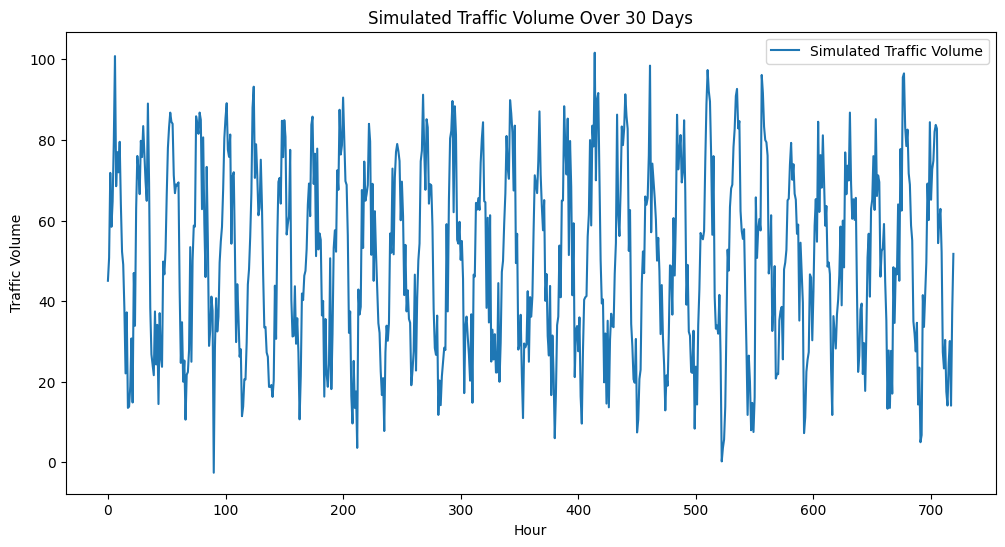

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameter dataset
days = 30
hours_per_day = 24
noise_level = 10

# Membuat titik waktu
time = np.arange(0, days * hours_per_day)

# Menghasilkan volume trafik menggunakan fungsi sinusoidal dengan noise
traffic_volume = 50 + 30 * np.sin(2 * np.pi * time / hours_per_day) + noise_level * np.random.randn(len(time))

# Membuat DataFrame
data = pd.DataFrame({
    'Hour': time,
    'TrafficVolume': traffic_volume
})

# Menyimpan dataset ke file CSV
data.to_csv('simulated_traffic_data.csv', index=False)

# Visualisasi data simulasi
plt.figure(figsize=(12, 6))
plt.plot(time, traffic_volume, label='Simulated Traffic Volume')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.title('Simulated Traffic Volume Over 30 Days')
plt.legend()
plt.show()


In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('simulated_traffic_data.csv')

# Normalisasi kolom TrafficVolume ke rentang [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedTrafficVolume'] = scaler.fit_transform(data[['TrafficVolume']])

# Menampilkan data setelah normalisasi
print(data.head())


   Hour  TrafficVolume  NormalizedTrafficVolume
0     0      46.843760                 0.453314
1     1      59.372954                 0.637725
2     2      66.669608                 0.745121
3     3      70.549260                 0.802223
4     4      73.206726                 0.841337


In [28]:
import numpy as np

# Definisikan ukuran training set (misalnya 80% untuk training, 20% untuk testing)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

# Membagi dataset
train_data = data[:train_size]
test_data = data[train_size:]

# Membuat sequence untuk LSTM (menggunakan sliding window)
def create_sequences(dataset, sequence_length=24):
    sequences = []
    labels = []
    for i in range(len(dataset) - sequence_length):
        seq = dataset[i:i+sequence_length]
        label = dataset[i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Membuat sequence dari kolom NormalizedTrafficVolume
sequence_length = 24  # Menggunakan 24 jam sebelumnya untuk memprediksi jam berikutnya
X_train, y_train = create_sequences(train_data['NormalizedTrafficVolume'].values, sequence_length)
X_test, y_test = create_sequences(test_data['NormalizedTrafficVolume'].values, sequence_length)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X_train: (552, 24), y_train: (552,)
Shape of X_test: (120, 24), y_test: (120,)


In [29]:
# Menampilkan 5 baris pertama dari data latih
print(train_data.head())

   Hour  TrafficVolume  NormalizedTrafficVolume
0     0      46.843760                 0.453314
1     1      59.372954                 0.637725
2     2      66.669608                 0.745121
3     3      70.549260                 0.802223
4     4      73.206726                 0.841337


In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Membangun model LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(24, 1)),  # Lapisan LSTM pertama
    LSTM(50, return_sequences=False),  # Lapisan LSTM kedua
    Dense(20, activation='relu'),  # Lapisan Dense pertama
    Dense(1)  # Lapisan Dense kedua
])

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Menampilkan ringkasan model
model.summary()


c:\Users\Rislan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,641 (123.60 KB)

 Trainable params: 31,641 (123.60 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Parameter pelatihan
epochs = 20  # Jumlah epoch
batch_size = 16  # Ukuran batch

# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,  # Menggunakan 20% data training untuk validasi
    verbose=1
)

# Menampilkan ringkasan hasil pelatihan
print(history.history)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010 - val_loss: 7.8914e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - val_loss: 8.3858e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010 - val_loss: 9.8371e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 8.6238e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 9.3324e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 8.7618e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 7.5280e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 8.4335e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6247e-04 - val_loss: 0.0020
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 8.7864e-04
Epoch 12/20
28/28 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


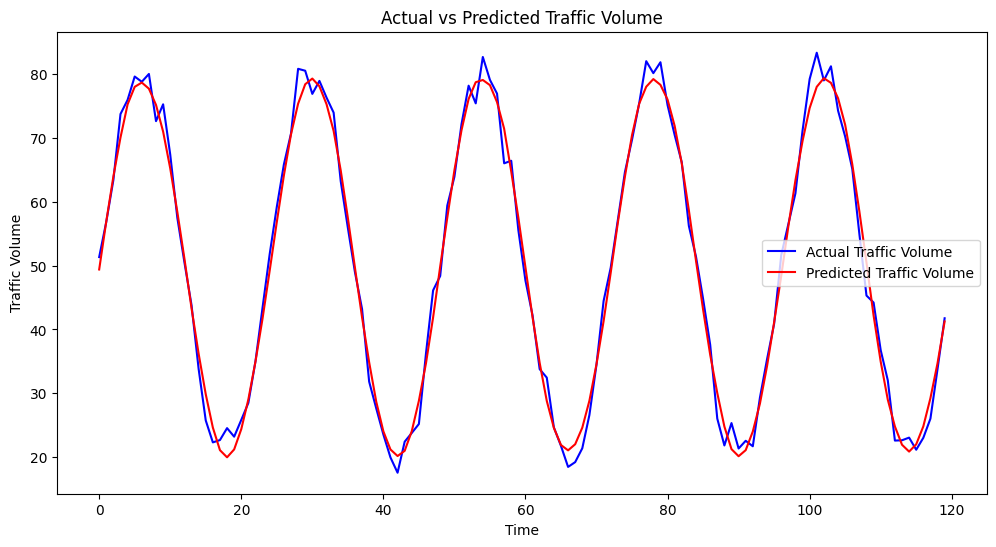

In [74]:
# Melakukan prediksi menggunakan model yang telah dilatih
predictions = model.predict(X_test)

# Denormalisasi hasil prediksi
predictions_denormalized = scaler.inverse_transform(predictions)

# Denormalisasi data aktual
y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot hasil prediksi vs data aktual
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label='Actual Traffic Volume', color='blue')
plt.plot(predictions_denormalized, label='Predicted Traffic Volume', color='red')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.legend()
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Menghitung MSE
mse = mean_squared_error(y_test_denormalized, predictions_denormalized)
print(f"Mean Squared Error (MSE): {mse}")

# Menghitung MAE
mae = mean_absolute_error(y_test_denormalized, predictions_denormalized)
print(f"Mean Absolute Error (MAE): {mae}")

# Menghitung R²
r2 = r2_score(y_test_denormalized, predictions_denormalized)
print(f"R²: {r2}")

Mean Squared Error (MSE): 5.326126786788052
Mean Absolute Error (MAE): 1.8892535172875782
R²: 0.9883747883494067


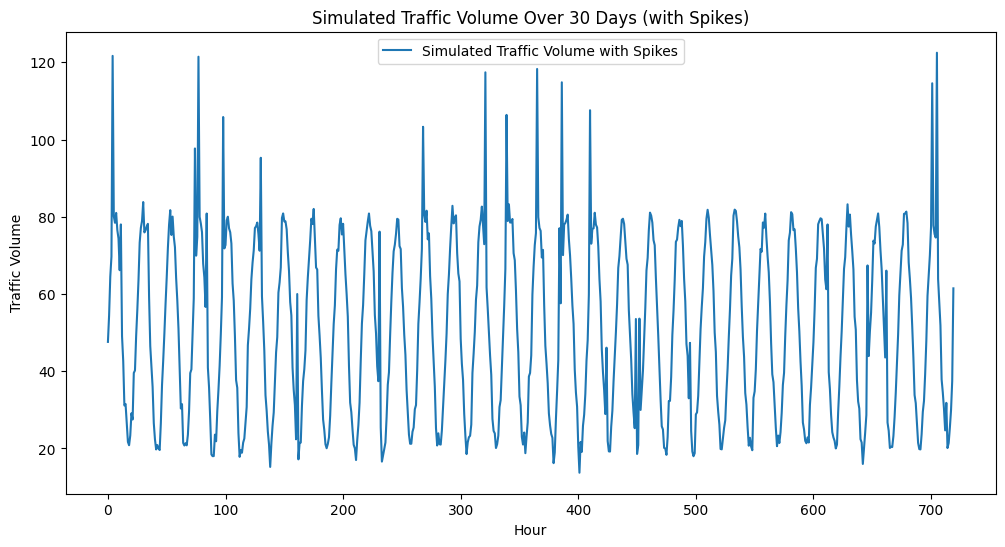

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameter dataset
days = 30
hours_per_day = 24
noise_level = 2
num_users = 100  # Jumlah pengguna unik

# Membuat titik waktu
time = np.arange(0, days * hours_per_day)

# Menghasilkan data trafik utama (TrafficVolume)
traffic_volume = 50 + 30 * np.sin(2 * np.pi * time / hours_per_day) + noise_level * np.random.randn(len(time))

# Membuat fitur tambahan
users = np.random.choice([f"User_{i}" for i in range(1, num_users + 1)], size=len(time))  # Pengguna yang mengakses
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
access_day = [days_of_week[i % len(days_of_week)] for i in range(days)] * hours_per_day  # Hari pengaksesan
bandwidth_consumption = traffic_volume * np.random.uniform(0.5, 1.5, size=len(time))  # Konsumsi bandwidth
bandwidth_resources = np.random.randint(10, 100, size=len(time))  # Bandwidth resources tersedia

# Fitur tambahan untuk faktor teknis dan eksternal
sudden_spike = (np.random.rand(len(time)) < 0.05) * np.random.randint(10, 50, size=len(time))  # Lonjakan trafik mendadak
traffic_volume += sudden_spike  # Menambahkan lonjakan ke volume trafik

overloading = traffic_volume > bandwidth_resources  # Overloading jika trafik melebihi sumber daya bandwidth
latency = np.random.uniform(10, 100, size=len(time)) * (1 + overloading)  # Latensi meningkat saat overloading

cyber_attack = np.random.choice([0, 1], size=len(time), p=[0.98, 0.02])  # Serangan siber dengan probabilitas kecil
physical_disruption = np.random.choice([0, 1], size=len(time), p=[0.95, 0.05])  # Gangguan fisik atau elektronik

# Membuat DataFrame dengan semua fitur
data = pd.DataFrame({
    'Hour': time,
    'User': users,
    'Day': access_day,
    'TrafficVolume': traffic_volume,
    'BandwidthConsumption': bandwidth_consumption,
    'BandwidthResources': bandwidth_resources,
    'SuddenSpike': sudden_spike,
    'Overloading': overloading,
    'Latency': latency,
    'CyberAttack': cyber_attack,
    'PhysicalDisruption': physical_disruption
})

# Menyimpan dataset ke file CSV
data.to_csv('enhanced_simulated_traffic_data.csv', index=False)

# Visualisasi data simulasi (contoh untuk TrafficVolume)
plt.figure(figsize=(12, 6))
plt.plot(time, traffic_volume, label='Simulated Traffic Volume with Spikes')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.title('Simulated Traffic Volume Over 30 Days (with Spikes)')
plt.legend()
plt.show()
